In [1]:
import sys
sys.path.append('../')

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np

from src.models.net import *
from src.si import *
from src.util import util as ut

/Users/giosuemigliorini/miniconda3/envs/cs274e/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

combined_dataloader = ut.get_doubleloader_mnist_and_svhn_data()

Using downloaded and verified file: data/extra_32x32.mat


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(
    dim = 28,
    dim_mults = (1,2,),
    flash_attn = True,
    channels=1,
    resnet_block_groups=4,
    attn_dim_head=32,
    attn_heads=2,
).to(device)

# model = SmallNet(dim=28).to(device)

si = EncoderDecoderInterpolant(model)
si = make_noisy(si, noise_coeff=.5)

In [4]:
num_params = [p.numel() for p in model.parameters()]
print('Number of parameters: ', sum(num_params))

Number of parameters:  594789


In [6]:
torch.save(model.state_dict(), '../notebooks/pretrained/demo_two_sided.pt')

In [7]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
si.train(combined_dataloader, optimizer, epochs,loss_type='velocity', eval_int=1, save_int=1, save_path='../notebooks/pretrained/demo_two_sided.pt')

  1%|          | 4/600 [00:09<23:10,  2.33s/it]


KeyboardInterrupt: 

In [8]:
x_initial = next(iter(combined_dataloader))[0][:10].to(device)

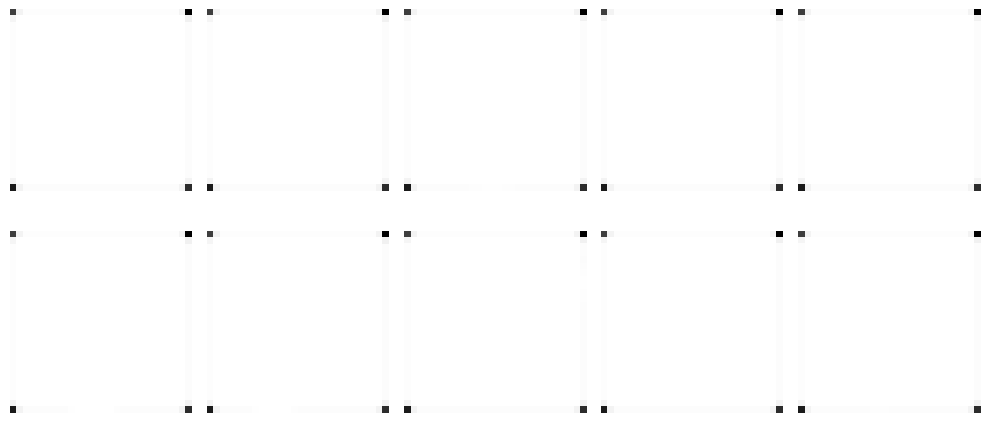

In [9]:
imgs = model(t=torch.tensor([1]) , x=x_initial)
# show the image
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
ax = ax.flatten()
for i, img in enumerate(imgs):
    ax[i].imshow(img.squeeze().detach().numpy(), cmap='gray')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [30]:
# class eta_to_b_model(torch.nn.Module):
#     def __init__(self, si):
#         super().__init__()
#         self.eta = si.model
#         self.a = si.a
#         self.b = si.b
#         self.da = si.da
#         self.db = si.db
#     def forward(self, t,x):
#         if t.dim() == 0:
#             t = t.unsqueeze(-1)
        
#         eta_out = self.eta(t,x)
#         return self.da(t)*eta_out + self.db(t)/self.b(t)*(x - self.a(t)* eta_out)

# b_model = eta_to_b_model(si)

In [31]:
# imgs = b_model(t=torch.tensor([0.001]) , x=x_initial)
# # show the image
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# for i, img in enumerate(imgs):
#     ax[i].imshow(img.squeeze().detach().numpy(), cmap='gray')
#     ax[i].axis('off')

In [40]:
class rvrs_model(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        if t.dim() == 0:
            t = t.unsqueeze(-1)
        return - self.model(1-t, x)

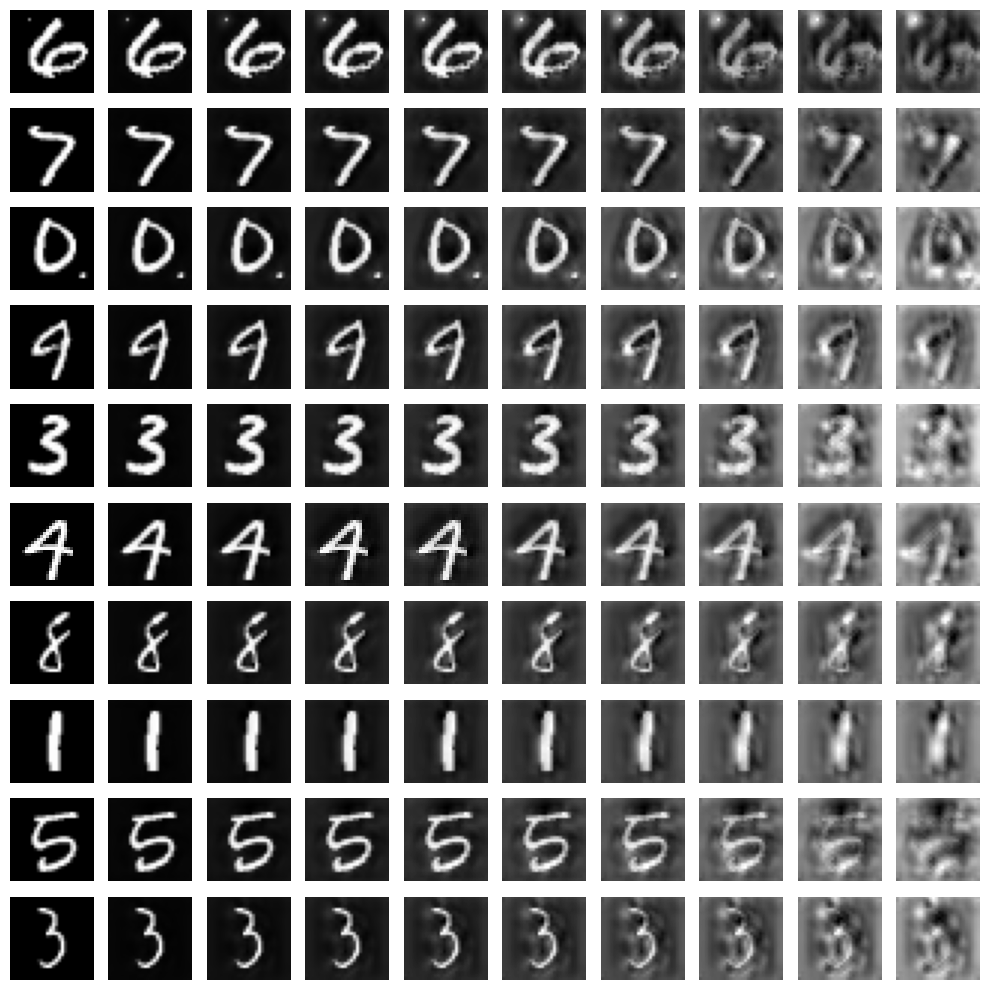

In [48]:
x_initial = next(iter(combined_dataloader))[0][:10].to(device)

n_eval = 10
n_samples = 10
# x_initial = torch.randn(n_samples, 1, 28, 28)

t = torch.linspace(0,1, n_eval, device=device)
inital_batch_size = x_initial.shape[0]

if n_samples > inital_batch_size:
    # if x_initial has less samples than n_samples, repeat x_initial at random to get n_samples
    n_new_samples = n_samples - inital_batch_size
    x_initial = torch.cat([x_initial, x_initial[torch.randint(0, inital_batch_size, (n_new_samples,))]], dim=0)
if n_samples < inital_batch_size:
    # if x_initial has more samples than n_samples, randomly choose n_samples samples from x_initial
    x_initial = x_initial[torch.randperm(inital_batch_size)[:n_samples]]


method = 'dopri5'
rtol = 1e-4
atol = 1e-4
out = odeint(model, x_initial, t, method=method, rtol=rtol, atol=atol)

# show the image
fig, axs = plt.subplots(n_samples, n_eval, figsize=(n_eval, n_samples))

for i in range(n_samples):
    for j in range(n_eval):
        axs[i, j].imshow(out[j][i].squeeze().detach().numpy(), cmap='gray')
        axs[i, j].axis('off')
    
plt.tight_layout()
plt.show()


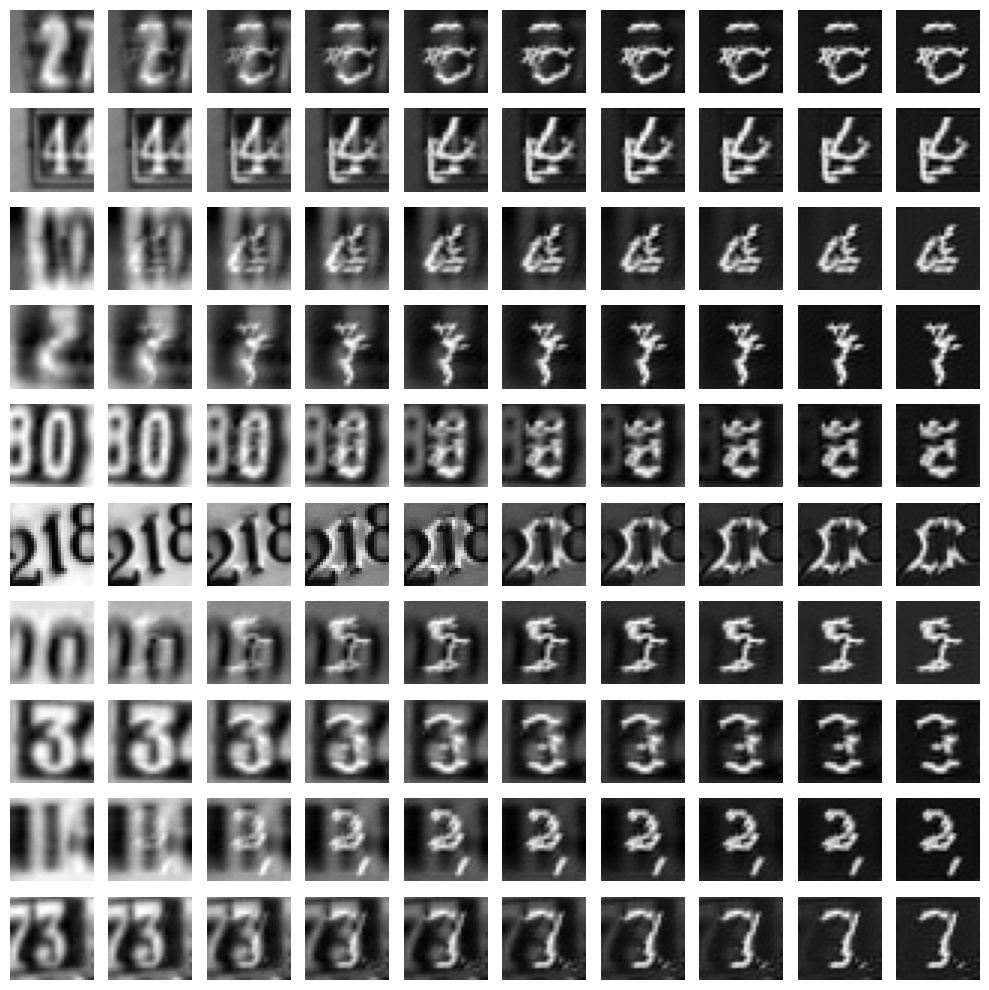

In [47]:
x_initial = next(iter(combined_dataloader))[1][:10].to(device)

reverse_model = rvrs_model(model)

n_eval = 10
n_samples = 10
# x_initial = torch.randn(n_samples, 1, 28, 28)

t = torch.linspace(0,1, n_eval, device=device)
inital_batch_size = x_initial.shape[0]

if n_samples > inital_batch_size:
    # if x_initial has less samples than n_samples, repeat x_initial at random to get n_samples
    n_new_samples = n_samples - inital_batch_size
    x_initial = torch.cat([x_initial, x_initial[torch.randint(0, inital_batch_size, (n_new_samples,))]], dim=0)
if n_samples < inital_batch_size:
    # if x_initial has more samples than n_samples, randomly choose n_samples samples from x_initial
    x_initial = x_initial[torch.randperm(inital_batch_size)[:n_samples]]


method = 'dopri5'
rtol = 1e-4
atol = 1e-4
out = odeint(reverse_model, x_initial, t, method=method, rtol=rtol, atol=atol)

# show the image
fig, axs = plt.subplots(n_samples, n_eval, figsize=(n_eval, n_samples))

for i in range(n_samples):
    for j in range(n_eval):
        axs[i, j].imshow(out[j][i].squeeze().detach().numpy(), cmap='gray')
        axs[i, j].axis('off')
    
plt.tight_layout()
plt.show()